# Trading Earnings Volatility

## Background

Quarterly earning announcements can cause potentially extreme moves in individual equities as companies under/over perform relative to expectation. These are previously announced events with known times, giving both day traders and large institutions the opportunity to place volatility and directional bets in the options marketplace, capitalizing on market reaction and the sentiment to the report.

To highlight this, we can look at the recent underlying volatility surrounding AMZN and GOOG earnings at the start of 2022, with Alphabet reporting after the market close on 2/1 and AMZN reporting after the market close on 2/2.

GOOG rallied from 2757 to 2960, a gain of 7.3% between the earnings report and the close on 2/2. (GOOGL very similar performance)
Amazon dropped from 3012 to 2776, losing more than 8% between the earnings report and the close on 2/3.

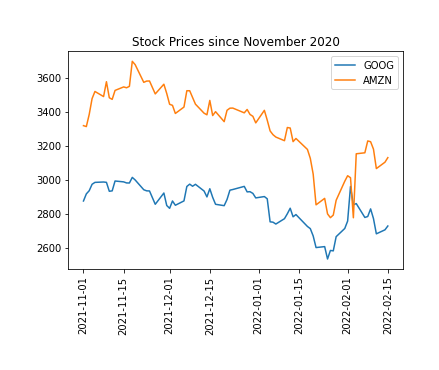

In [1]:
from IPython.display import Image
Image('GOOG_AMZN.png')

## Hypothesis

Stocks experience higher than average realized volatility around quarterly earnings announcements.


The average realized volatility of an individual equity stock through its historical earnings reports relative to its baseline performance is predictive of how much we would expect it to move on an upcoming earnings press release.


If the shortest dated at the money options for an issuer is priced on an implied volatility higher than our prediction for realized volatility going into an earnings, there is a positive expected value in selling the at the money straddle. If the straddle is priced below our prediction for realized volatility, there is a positive expected value position in buying the straddle. 


## Data

We will be using the WRDS OptionsMetrics database to get our data. Specifically, 'OptionMetrics - Historical Volatility' and 'OptionMetrics - Option Prices'.

### Required:
1. Historical earnings dates
2. Daily realized volatility calculations
3. Daily option implied volatilities
4. Daily market close bid/ask prices for the nearest term 50d call and put option

### May Want to Consider:
5. Daily option volumes
6. Earnings data vs expectations

## Strategy Execution

Select a subset of companies that we expect would be a good candidate for this volatility trading strategy. We will select stocks with liquid options markets with earnings announcements that have sparked increased options trading speculation. We also need to select companies that have enough of an earnings history to form a prediction.

For each stock selected:
    1. Compare realized volatility on and the day after earnings announcements to their average realized volatility in the training data set
    2. Calculate an expectation for realized volatility for the future earnings dates in a testing data set and compare it to the implied volatility of the at the money straddle in the day's preceeding the earnings dates.
    3. Construct a sizing curve depending on the difference between implied volatility vs expected realized volatility. Depending on the difference, trade up to 10k notional buying or selling the at the money straddle at the close price BBO.
    4. Close out our straddle position T+1 after earnings date.
    


## Analysis and Data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import statsmodels.api as sm
quandl.ApiConfig.api_key = 'bULWv51MebBBGL56KGys'
from functions_folder.functions import *

#### Select historical adjusted close prices for companies with liquid options markets

In [4]:
#Our option price data ends on 12/31/20 so we will end our analysis on that date.
start = '2015-01-01'
end = '2020-12-31'

tickers = ['GOOG', 'AMZN', 'SNAP', 'MSFT', 'FB', 'TSLA', 'NVDA', 'JPM', 'AVGO', 'VZ']

adj_close = quandl.get_table("QUOTEMEDIA/PRICES", 
                        ticker = tickers,  
                        qopts = { 'columns': ['ticker', 'date', 'adj_close']},  
                        date = { 'gte': start, 'lte': end}, 
                        paginate = True)

adj_close.head()

,ticker,date,adj_close
None,,,
0,VZ,2020-12-31,55.537089
1,VZ,2020-12-30,54.960449
2,VZ,2020-12-29,55.593808
3,VZ,2020-12-28,55.754511
4,VZ,2020-12-24,55.622167


#### 

### Financial statement filing date

In [5]:
# earnings dates (FC/FILING_DATE)
zacks_fc = quandl.get_table('ZACKS/FC', 
                    per_end_date = { 'gte': start, 'lte': end },
                    ticker = tickers, 
                    paginate=True)

In [6]:
# quarterly report filing dates
filing_dates = zacks_fc[zacks_fc['per_type'] == 'Q'][['ticker', 'filing_date']]
filing_dates

,ticker,filing_date
None,,
6,AMZN,2015-04-24
7,AMZN,2015-07-24
8,AMZN,2015-10-23
9,AMZN,2016-01-29
10,AMZN,2016-04-29
...,...,...
292,VZ,2020-02-21
293,VZ,2020-04-27
294,VZ,2020-07-28


#### Historical option data

In [7]:
# this is limited to options with expiry less than 15 days from current date.
option_data = pd.read_csv('data/OptionMetrics.csv.gz', sep = ',')

In [8]:
# match date format of quandl data
option_data['date'] = option_data.apply(lambda row: row.date.replace('/', '-', 2), axis = 1)
option_data['exdate'] = option_data.apply(lambda row: row.exdate.replace('/', '-', 2), axis = 1)

In [9]:
# strike_price = strike * 1000
option_data.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,optionid,ticker,index_flag,issuer,exercise_style
0,2015-01-02,2015-01-09,C,235000,71.90,75.55,0,0.919228,0.986198,106179177,AMZN,0,AMAZON.COM INC.,A
1,2015-01-02,2015-01-09,C,240000,67.00,70.85,0,0.955372,0.975301,106179178,AMZN,0,AMAZON.COM INC.,A
2,2015-01-02,2015-01-09,C,245000,61.85,65.35,0,0.695843,0.992689,106134398,AMZN,0,AMAZON.COM INC.,A
3,2015-01-02,2015-01-09,C,250000,57.15,60.45,0,0.771536,0.978447,106134399,AMZN,0,AMAZON.COM INC.,A
4,2015-01-02,2015-01-09,C,255000,52.00,55.45,0,0.673865,0.981649,106134400,AMZN,0,AMAZON.COM INC.,A


### Functions

### Analysis

In [10]:
# there are 224 filing dates
# filing_dates[filing_dates['exdate'] != 0]

# post_bid and post_offer and post_volume are data 1 day after earnings
# everything else is n days before earnings
# analyze vol_diff vs. change in bid/offer

In [11]:
strat = Earnings_strat(filing_dates, option_data, adj_close, vola_window = 7)
opts = strat.clean_data()
vol_straddle = strat.vol_vs_straddle(1,1)

vol_straddle['initial_straddle_price'] = vol_straddle['best_bid'] + vol_straddle['best_offer']
vol_straddle['final_straddle_price']  = vol_straddle['post_bid'] + vol_straddle['post_offer']
vol_straddle['straddle_change'] = vol_straddle['final_straddle_price'] - vol_straddle['initial_straddle_price']

# Parameterizing Trading Strategy

#### Understanding the Volatility Edge Spreads

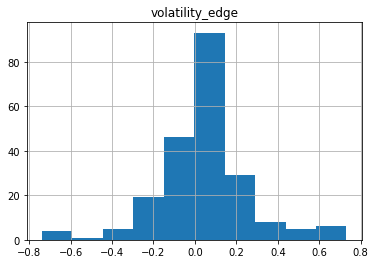

Average Vol Spread 0.0438
Standard Deviation Vol Spread 0.2154


In [12]:
vol_straddle.hist('volatility_edge')
plt.show()
print('Average Vol Spread {:.4f}'.format(vol_straddle['volatility_edge'].mean()))
print('Standard Deviation Vol Spread {:.4f}'.format(vol_straddle['volatility_edge'].std()))

Looking at a historical distribution of the implied - realized vol spread, the average implied volatility is priced at a premium to realized volatility; implied volatility takes into account very rare events and the potential for extreme downside moves and compensates the seller for this addiitional risk. Using this distribution we will use an average vol spread of .04 instead of assume that on average implied is priced at the current realized volatility level. There is significant standard deviation in our data as well. The shape of this distribution can help 
inform how we size. 

Breaking down our testing data set, we can look at some sample stats to decide how we want to paramaterize our trading algorithm. The first decision points we can focus on are: which stocks should we trade and how much volatility edge should we demand in either direction to make a trade. To make a decision on the stocks in our portfolio, we calculate the correlation between the volatility edge and the change in straddle price across earnings. What we are looking for is stocks with big negative correlation values. An option with an implied vol priced high above its realized volatility means there is a big straddle down fit after the event. An option priced on an implied volatility lower than its realized leads to a big straddle up fit. Those stocks that don't exhibit such correlations we will drop from consideration.

The benefit to limiting our test to specific stocks/volatility edge values is it should reduce variance in our strategy performance and reduce tracking error from our expected PnLs. The downside is it lowers the total number of profit making opportunities we have.



#### Selecting Stocks

We use the first 100 events as our training data set. We looked at basic correlation and beta data between how much the difference in realized vs implied volatility predicted the change in straddle price to narrow down our stocks to those we think have the highest chance of profitable performance trading the event volatility in the testing data set.

**Training Set:**


 Correlations between the spread between implied and realized volatility and change in straddle price 

          corr      beta
MSFT -0.918267 -0.045021
FB   -0.885643 -0.047308
VZ   -0.625048 -0.037524
SNAP -0.527329 -0.093715
AVGO -0.509358 -0.012549
GOOG -0.390365 -0.001347
TSLA -0.363830 -0.036350
AMZN -0.045054 -0.001228
NVDA -0.034116 -0.003600
JPM   0.101880  0.032969

Overall Strategy correlation: -0.2641
Overall Beta: -0.00776


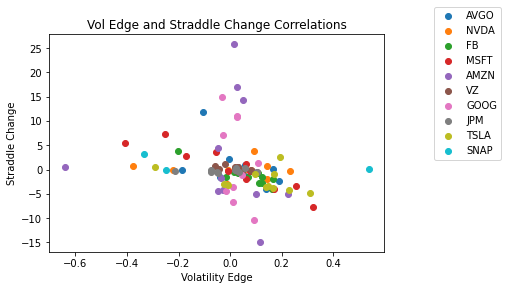

In [13]:
training = vol_straddle.reset_index()[:100]
DisplayCorrelations(training)

JPM, AMZN, NVDA all did not show strong correlations. We will remove them from the strategy and only use the remaining tickers in the test set, shown below:

**Training Subset:**


 Correlations between the spread between implied and realized volatility and change in straddle price 

          corr      beta
MSFT -0.918267 -0.045021
FB   -0.885643 -0.047308
VZ   -0.625048 -0.037524
SNAP -0.527329 -0.093715
AVGO -0.509358 -0.012549
GOOG -0.390365 -0.001347
TSLA -0.363830 -0.036350

Overall Strategy correlation: -0.4402
Overall Beta: -0.01570


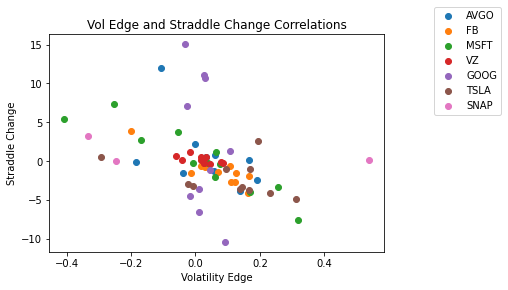

In [14]:
training_sub = training[~training['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
DisplayCorrelations(training_sub)

The above scatter plot shows stronger overall correlation with AMZN, JPM, and NVDA removed.

## Setting Edge Spacer

Below a certain absolute edge threshold, the edge won't be sufficient enough to cover the risk of the trade. It also doesn't have a very strong correlation with the preceeding straddle fit. Experimenting with different minimum trading widths, it looks like demanding at least 5 vol points of edge from the mean removes a decent number of trades that had very low correlation of .0049 and betas close to 0 (26 trade instances) while the remaining 42 trades shown after now have a correlation of -0.51 and a beta of -.02. We will sample a few different minimum trading widths in our backtest, we will start with ~5 vol points.

### Below Min Width


 Correlations between the spread between implied and realized volatility and change in straddle price 

          corr      beta
FB   -0.997682 -0.044255
AVGO -0.771161 -0.001875
VZ   -0.497390 -0.040600
MSFT -0.056868 -0.015432
GOOG  0.376392  0.001476
TSLA       NaN  0.002481

Overall Strategy correlation: 0.0049
Overall Beta: 0.00060


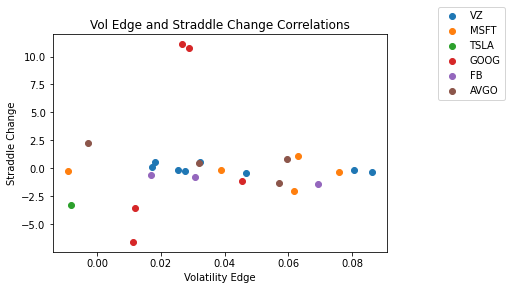

Total obersevations: 68
Total trades inside spacer: 26


In [15]:
training_sub = training[~training['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
training_sub_inside = training_sub[abs(training_sub['volatility_edge'] - training_sub['volatility_edge'].mean()) < .05]
DisplayCorrelations(training_sub_inside)
print('Total obersevations: {}'.format(training_sub.shape[0]))
print('Total trades inside spacer: {}'.format(training_sub_inside.shape[0]))

#### Above Min Width


 Correlations between the spread between implied and realized volatility and change in straddle price 

          corr      beta
MSFT -0.933516 -0.045884
FB   -0.883096 -0.047473
GOOG -0.584546 -0.003403
SNAP -0.527329 -0.093715
AVGO -0.502677 -0.013045
TSLA -0.412233 -0.040632
VZ    0.584716 -0.035972

Overall Strategy correlation: -0.5146
Overall Beta: -0.02140


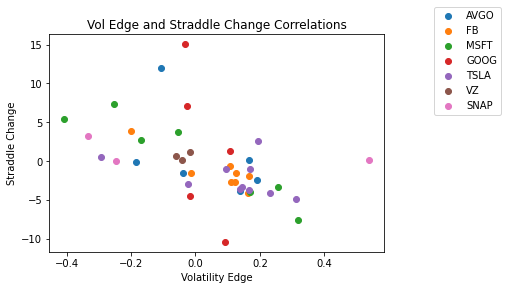

Total obersevations: 68
Total trades outside spacer: 42


In [16]:
testing_sub = training[~training['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
training_sub_outside = training_sub[abs(training_sub['volatility_edge'] - training_sub['volatility_edge'].mean()) > .05]
DisplayCorrelations(training_sub_outside)
print('Total obersevations: {}'.format(training_sub.shape[0]))
print('Total trades outside spacer: {}'.format(training_sub_outside.shape[0]))

testing =  vol_straddle.reset_index()[100:]
testing_sub = testing[~testing['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
testing_sub_outside = testing_sub[abs(testing_sub['volatility_edge'] - testing_sub['volatility_edge'].mean()) > .05]

We have stronger correlations when only considering trades outside our spacer of 5 volatility points.

### Fees and Slippage

As our stratetgy does not require frequent repositioning and day trading, the overall costs of trading our strategy are limited by the costs to enter and exit the position. All the stocks we are looking at are multi listed products that trade across several large exchanges. At the time of trade, we do not know which exchange is posting the best bid or offer - we only have visability on what the price and size of that market are. At the time of execution, we will be charged per leg by the exchange and will use an approximate exchange fee of 0.05/leg in our analysis. Looking at pricing from the exchanges, I think this is a reasonable estimate to use.

The greater impact on our strategy performance is the liquidity and market width at the time of trade. We are selecting trade dates and times with low liquidity. As a market trader, this is to our detriment as displayed quotes will widen out going into the close on these days. There might be a decent amount of hidden liquidity that exists between what we see quoted but we will assume we don't have access to trade inside the published quotes and must lift the offer/hit the bid.

### Sizing Curves

We will consider two potential sizing curves: a linear sizing curve and a s-curve. Positional trade size is determined by how much edge we see in the trade vs the average. Our sizing curve is symmetric around the average. With a linear sizing curve, we add the same bet size to each additional vol point of edge that we see. Using an s-shape curve, we will placer smaller bets than the linear sizing curve when edge is around 0 and also really size up when we get to edge point values close to the extremes of our historical distribution. The y axis here is as % of max bet size. Looking at some of the volume data, I think it's reasonable to assume we will be able to trade up to 250 straddles at the displayed prices - this is not something we can guarantee though. 

For a baseline, we will compare the performance of these trading curves to a backtest where we trade the same total quantity of options regardless of the edge we see as long as the edge exceeds our spacer. This strategy is naive and I wouldn't expect it to work as well as one where we take into account edge at time of trade to decide our trade size.

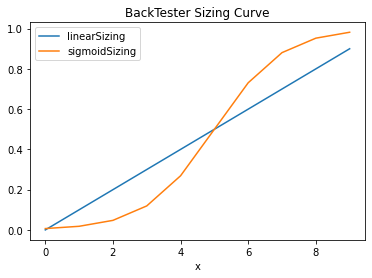

In [17]:
DisplaySizing()

### Constant Trade Size Performance

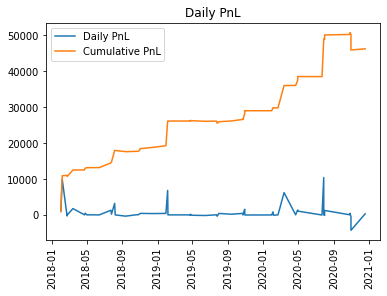

,Long PnL,Short PnL,Total PnL,Average Trade Size,Min Trade Size,Max Trade Size
ticker,,,,,,
GOOG,14326.59,2995.48,17322.06,100.0,100.0,100.0
TSLA,2861.32,11765.87,14627.19,100.0,100.0,100.0
AVGO,7893.12,545.09,8438.21,100.0,100.0,100.0
MSFT,1679.60,3020.48,4700.08,100.0,100.0,100.0
FB,35.99,715.11,751.10,100.0,100.0,100.0
SNAP,125.97,118.02,243.99,100.0,100.0,100.0
VZ,122.97,47.01,169.98,100.0,100.0,100.0


PnL from shorts:                    19207.05
PnL from longs:                     27045.56
Trading Costs:                      59.00
Total PnL After Cost:               46193.61
Standard Deviation of Total PnL:    2279.74
PnL per 1 lot of straddles wagered: 7.84
Overall Sharpe Ratio                0.34


In [18]:
df = Backtest(testing_sub_outside)

### Linear Trade Size Performance


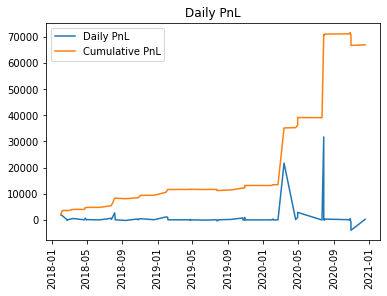

,Long PnL,Short PnL,Total PnL,Average Trade Size,Min Trade Size,Max Trade Size
ticker,,,,,,
TSLA,2515.13,33106.97,35622.10,97.19,3.85,304.88
AVGO,22028.56,405.27,22433.83,83.52,0.27,349.55
MSFT,360.95,6265.57,6626.52,150.62,8.26,359.96
FB,886.24,753.25,1639.50,95.21,6.16,196.44
SNAP,93.68,227.99,321.67,166.14,58.02,315.26
GOOG,-810.80,1024.06,213.26,53.03,1.79,120.19
VZ,43.47,45.82,89.28,45.81,8.61,133.82


PnL from shorts:                    41828.94
PnL from longs:                     25117.23
Trading Costs:                      63.16
Total PnL After Cost:               66883.00
Standard Deviation of Total PnL:    4995.59
PnL per 1 lot of straddles wagered: 10.60
Overall Sharpe Ratio                0.23


In [19]:
df = Backtest(testing_sub_outside, 'Linear')

### S-Curve Trade Size Performance

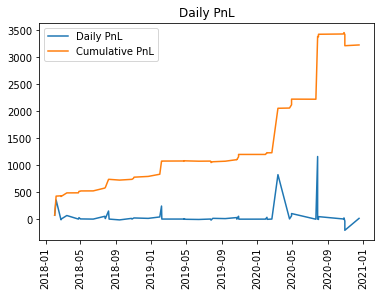

,Long PnL,Short PnL,Total PnL,Average Trade Size,Min Trade Size,Max Trade Size
ticker,,,,,,
TSLA,135.51,1228.76,1364.27,100.88,34.50,358.46
AVGO,884.92,24.56,909.48,105.27,33.54,497.13
GOOG,458.37,115.88,574.25,53.27,33.94,86.59
MSFT,61.23,238.91,300.14,160.14,35.74,535.68
FB,20.95,36.68,57.64,80.61,35.14,157.08
SNAP,5.70,9.25,14.95,155.66,53.02,387.10
VZ,4.84,2.27,7.11,52.31,35.83,96.38


PnL from shorts:                    1656.32
PnL from longs:                     1571.52
Trading Costs:                      64.03
Total PnL After Cost:               3163.80
Standard Deviation of Total PnL:    192.19
PnL per 1 lot of straddles wagered: 0.50
Overall Sharpe Ratio                0.28


In [20]:
df = Backtest(testing_sub_outside, 'S-curve')

## Baseline Comparison

Here we will compare our strategy to a more naive strategy to measure our out-performance. We will buy or sell based on volatility edge, same as above, but we will now enter and exit the position before earnings. With this we will be able to deduce how much edge we capture from entering before earnings and exiting after.

In [21]:
vol_straddle_comp = strat.vol_vs_straddle(days_before = 4,days_after = -2)

vol_straddle_comp['initial_straddle_price'] = vol_straddle_comp['best_bid'] + vol_straddle_comp['best_offer']
vol_straddle_comp['final_straddle_price']  = vol_straddle_comp['post_bid'] + vol_straddle_comp['post_offer']
vol_straddle_comp['straddle_change'] = vol_straddle_comp['final_straddle_price'] - vol_straddle_comp['initial_straddle_price']


 Correlations between the spread between implied and realized volatility and change in straddle price 

          corr      beta
JPM  -0.957373 -0.237354
SNAP -0.831530  0.495459
TSLA -0.511442 -0.014638
AVGO -0.452570 -0.018930
FB   -0.429517 -0.054674
GOOG -0.216226 -0.003264
NVDA -0.200140 -0.018203
AMZN  0.143421  0.001591
MSFT  0.342877  0.181992
VZ    0.532602  0.121103

Overall Strategy correlation: -0.0504
Overall Beta: -0.00185


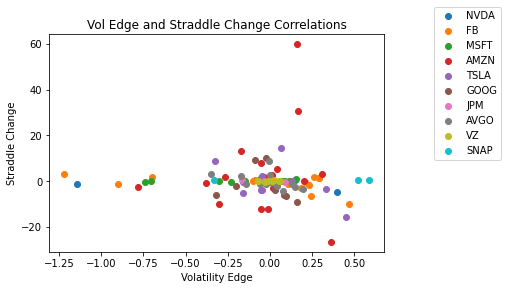

In [22]:
training_comp = vol_straddle_comp.reset_index()[:100]
DisplayCorrelations(training_comp)

Here we see a much lower and almost non-existent correlation of -0.05, compared to -0.26 in our strategy. 

In [23]:
testing_comp =  vol_straddle_comp.reset_index()[100:]
testing_comp_sub = testing_comp[~testing_comp['ticker'].isin(['AMZN', 'JPM', 'NVDA'])]
testing_comp_sub_outside = testing_comp_sub[abs(testing_comp_sub['volatility_edge'] - testing_comp_sub['volatility_edge'].mean()) > .05]

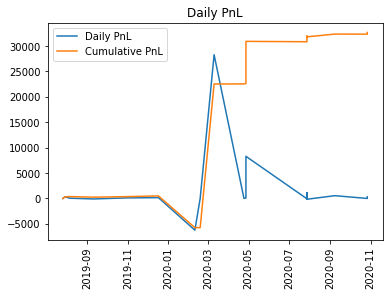

,Long PnL,Short PnL,Total PnL,Average Trade Size,Min Trade Size,Max Trade Size
ticker,,,,,,
AVGO,28288.66,586.41,28875.06,213.69,46.20,644.54
TSLA,-6253.94,8267.47,2013.53,108.69,7.60,245.13
GOOG,323.13,1129.74,1452.87,95.91,87.56,104.26
MSFT,171.84,0.00,171.84,86.64,85.36,87.92
FB,19.25,83.78,103.03,78.83,14.98,131.44
VZ,0.00,56.18,56.18,29.05,8.59,56.72


PnL from shorts:                    10123.57
PnL from longs:                     22548.94
Trading Costs:                      19.48
Total PnL After Cost:               32653.03
Standard Deviation of Total PnL:    7073.52
PnL per 1 lot of straddles wagered: 16.77
Overall Sharpe Ratio                0.26


In [24]:
df = Backtest(testing_comp_sub_outside, 'Linear')

Here we have a total PnL of 32653 compared to 66883 in our strategy. Most of the PnL in the baseline strategy occurs in March 2020, when volatility spiked accross all markets.

### Analysis

Overall, we were pretty happy with the performance of our trading strategy. It does seem like there can be profitable opportunities surrounding these earnings events. It's definitely a high risk strategy however, even though these PnLs are solid for the testing timeframe, the standard deviation is pretty high as straddles are a very inherently risky trade especially without a gamma hedging strategy. For this reason, a few improvements to this strategy might include hedges against extreme underlying moves.


This strategy performed very well on July 28, 2020 when TSLA released its Q2 earnings. The straddle was priced on an 85 volatility while the underlying was realizing ~ a 23 realized volatility using a 7 day rolling average. The TSLA atm straddle expiring on July 31, 2021 was worth 181.4 before the earnings came out and worth 77.35 after. Shares of Tesla rose as much as 3.2% to $678.40 in after market trading, but the implied 1 day move for a share of TSLA on a 85 vol is 85/sqrt(252), or approximately 5.35%

Another notable performer was AVGO on March 13, 2020. AVGO was priced on a 68 implied volatility while realizing a 133% volatility calculated using a 7 day rolling average. The straddle price went from 36/40 to 95.20. Obviously a significant caveat with reading in to this data point is that the S&P 500 and other large economic indicies were experiencing massive drawdorns and surges in implied volatility this week as covid lockdowns began. Regardless of a stock (and it's earnings information) buying volatility before the market crash had a highly probabilistic pay off.  

AVGO actually updated their guidance during their Q1 earnings - saying 'In light of the uncertainties in the global business environment arising from the effects of COVID-19, the Company is withdrawing its prior annual guidance for fiscal year 2020, and providing guidance for its second fiscal quarter.' I think this data point needs to be heavily discounted if not removed from the sample if we want projections that aren't as dependent on overall market vol.

Another noticable earnings announcement was Alphabet on October 30, 2020. Our model saw 20 vol point of edge to buy the GOOG ATM straddle with the implied volatility 48% - implying a 3% move in the underlying.  The underlying only rallied from 1621 to 2626 however 0 this one is really interesting because the straddle bet would have paid off if we had timed the bet slightly differently with GOOG rallying to 1763 on Nov 5th. As with all trading strategies the timing is very important. I think there is a lot of different ways to experiment with the timing here and having intraday data would be really useful in deciding execution timing. 

In [25]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import statsmodels.api as sm

# def DisplaySizing():
#     def logistic(x, L=1, x_0=5, k=1):
#         return L / (1 + np.exp(-k * (x - x_0)))

#     df = pd.DataFrame()
#     df['x'] = range(0, 10, 1)
#     df['x'] = df['x']
#     df['linearSizing'] = df['x'] /10
#     df['sigmoidSizing'] = df['x'].apply(logistic)
#     df.set_index('x', inplace = True)
#     df.plot(title= 'BackTester Sizing Curve')

# def DisplayCorrelations(test_set):
#     print('\n Correlations between the spread between implied and realized volatility and change in straddle price \n')
#     table = {}
#     for tickerName in test_set['ticker'].unique():
#         df = test_set[test_set['ticker'] == tickerName]

#         model = sm.OLS(df['volatility_edge'].astype(float), df['straddle_change'].astype(float))
#         results = model.fit()

#         df['straddle_change'] = df['straddle_change'].astype(float)

#         plt.scatter(df['volatility_edge'], df['straddle_change'], label=tickerName)
#         res = [df.corr().loc['volatility_edge', 'straddle_change'], results.params[0]]
#         table[tickerName] = res

#     plt.xlabel('Volatility Edge')
#     plt.ylabel('Straddle Change')
    
#     res_df = pd.DataFrame.from_dict(table, orient='index', columns=['corr', 'beta'])
#     print(res_df.sort_values(by=['corr']))

#     test_set['straddle_change'] = test_set['straddle_change'].astype(float)
#     print('\nOverall Strategy correlation: {:.4f}'.format(test_set.corr().loc['volatility_edge', 'straddle_change']))
#     model = sm.OLS(test_set['volatility_edge'].astype(float), test_set['straddle_change'].astype(float))
#     results = model.fit()
#     print('Overall Beta: {:.5f}'.format(results.params[0]))
#     plt.title('Vol Edge and Straddle Change Correlations')
#     plt.legend(loc="upper center", bbox_to_anchor=(1.25, 1.15), ncol=1)
#     plt.show()

# def Backtest(df, sizing=None, quantity=500):
#     df['shortPnL'] = 0
#     df['longPnL'] = 0

#     # we hold each position for two days. assume borrow at 3%, lend at 2%
#     lending_factor = np.exp(-.02 * (2 / 252))
#     funding_factor = np.exp(-.03 * (2 / 252))

#     def logistic(x, L=1, x_0=5, k=1):
#         return L / (1 + np.exp(-k * (x - x_0)))

#     for index, row in df.iterrows():

#         ### implied exceeds realized, we sell the straddle
#         if row['volatility_edge'] > 0 and sizing == None:
#             df.at[index, 'shortPnL'] += (-1 * df.at[index, 'straddle_change'] * 100) / lending_factor
#             df.at[index, 'tradeSize'] = -100
#         elif row['volatility_edge'] > 0 and sizing == 'Linear':
#             df.at[index, 'shortPnL'] += (-1 * df.at[index, 'straddle_change'] * abs(
#                 df.at[index, 'volatility_edge']) * quantity) / lending_factor
#             df.at[index, 'tradeSize'] = -1 * abs(df.at[index, 'volatility_edge']) * quantity
#         elif row['volatility_edge'] > 0 and sizing == 'S-curve':
#             df.at[index, 'shortPnL'] += (-1 * df.at[index, 'straddle_change'] * logistic(
#                 2 * abs(df.at[index, 'volatility_edge'])) * quantity) / lending_factor
#             df.at[index, 'tradeSize'] = -1 * logistic(4 * abs(df.at[index, 'volatility_edge'])) * quantity * 10

#             ##realized exceeds implied, we buy the straddle
#         if row['volatility_edge'] < 0 and sizing == None:
#             df.at[index, 'longPnL'] += df.at[index, 'straddle_change'] * 100 * funding_factor
#             df.at[index, 'tradeSize'] = 100
#         elif row['volatility_edge'] < 0 and sizing == 'Linear':
#             df.at[index, 'longPnL'] += df.at[index, 'straddle_change'] * abs(df.at[index, 'volatility_edge']) * quantity * funding_factor
#             df.at[index, 'tradeSize'] = abs(df.at[index, 'volatility_edge']) * quantity
#         elif row['volatility_edge'] < 0 and sizing == 'S-curve':
#             df.at[index, 'longPnL'] += df.at[index, 'straddle_change'] * logistic(
#                 2 * abs(df.at[index, 'volatility_edge'])) * quantity * funding_factor
#             df.at[index, 'tradeSize'] = logistic(4 * abs(df.at[index, 'volatility_edge'])) * quantity * 10

#         df.at[index, 'totalPnL'] = df.at[index, 'shortPnL'] + df.at[index, 'longPnL']

#     plt.plot(df['today'], df['totalPnL'], label='Daily PnL')
#     plt.plot(df['today'], df['totalPnL'].cumsum(), label='Cumulative PnL')
#     plt.title('Daily PnL')
#     plt.xticks(rotation=90)
#     plt.legend()
#     plt.show()
#     table = pd.DataFrame()

#     for tickerName in df['ticker'].unique():
#         sub = df[df['ticker'] == tickerName]
#         table = table.append(
#             {'ticker': tickerName, 'Long PnL': sub['longPnL'].sum(), 'Short PnL': sub['shortPnL'].sum(),
#              'Total PnL': sub['longPnL'].sum() + sub['shortPnL'].sum(), \
#              'Average Trade Size': abs(sub['tradeSize']).mean(), 'Min Trade Size': abs(sub['tradeSize']).min(),
#              'Max Trade Size': abs(sub['tradeSize']).max()}, ignore_index=True)

#     display(table.set_index('ticker').sort_values('Total PnL', ascending=False).round(2))

#     costs = abs(df['tradeSize']).sum() * .005 * 2

#     print('PnL from shorts:                    {:.2f}'.format(df['shortPnL'].sum()))
#     print('PnL from longs:                     {:.2f}'.format(df['longPnL'].sum()))
#     print('Trading Costs:                      {:.2f}'.format(costs))
#     print('Total PnL After Cost:               {:.2f}'.format(df['totalPnL'].sum() - costs))
#     print('Standard Deviation of Total PnL:    {:.2f}'.format(df['totalPnL'].std()))
#     print('PnL per 1 lot of straddles wagered: {:.2f}'.format(df['totalPnL'].sum() / abs(df['tradeSize']).sum()))
#     print('Overall Sharpe Ratio                {:.2f}'.format(df['totalPnL'].mean() / df['totalPnL'].std()))

#     return df

# class Earnings_strat():
    
#     def __init__(self, filing_dates_df, option_data_df, adj_close_df, vola_window):
#         self.filing_dates_df = filing_dates_df
#         self.option_data_df = option_data_df
#         self.adj_close_df = adj_close_df
#         self.vola_window = vola_window
#         self.data_cleaned = False
        
#     def __calc_rolling_vola(self):
        
#         close_vola_df = pd.DataFrame()
        
#         for t in self.adj_close_df.ticker.unique():
#             df = self.adj_close_df[self.adj_close_df['ticker'] == t]
#             df = (df['adj_close'].rolling(self.vola_window).std() * np.sqrt(252)) / df['adj_close']
#             close_vola_df = pd.concat([close_vola_df, df], axis = 0)
            
#         close_vola_df=close_vola_df.rename(columns={0:"vola_{}day".format(self.vola_window)})
#         close_vola_df = pd.concat([self.adj_close_df, close_vola_df], axis = 1)
        
#         return close_vola_df
    
#     # this function returns the 50 delta calls and puts for exdate immediately after filing_date
#     def filter_opts(self):
                
#         self.opt_expiry = {}
#         result = pd.DataFrame(columns = ['ticker', 'filing_date', 'exdate'])
        
#         # find option expiring after earnings date
#         for s in self.option_data_df['ticker'].unique():
        
#             filing = pd.DataFrame(self.filing_dates_df[self.filing_dates_df['ticker'] == s])
#             options = pd.DataFrame(self.option_data_df[self.option_data_df['ticker'] == s])
    
#             options['exdate'] = pd.to_datetime(options['exdate'])
#             filing['filing_date'] = pd.to_datetime(filing['filing_date'])
        
#             # want options that expire after filing date
#             filing['filing_date'] = filing['filing_date'] + pd.Timedelta('1 days')
        
#             filing_exdate = []
        
#             for d in filing['filing_date']:
#                 try:
#                     date = options[options['exdate'] > d].head(1).exdate.item()
                    
#                     result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
#                                           ignore_index = True)
#                 except ValueError: # error raised if no option expiry after final filing date
#                     continue

#         result['filing_date'] = pd.to_datetime(result['filing_date'])
#         result['exdate'] = pd.to_datetime(result['exdate'])
#         self.filing_dates_df = pd.DataFrame(result)
        
#         self.option_data_df['exdate'] = pd.to_datetime(self.option_data_df['exdate'])
        
#         # merge on exdate just after filing_dates
#         self.option_data_df = pd.merge(self.option_data_df, self.filing_dates_df,
#                                        on = ['ticker', 'exdate'])
        
#         # get options closest to delta=50 for each expiry
#         res = pd.DataFrame()
#         for s in self.option_data_df['ticker'].unique():
            
#             call_d, put_d = {}, {}
            
#             df = self.option_data_df[self.option_data_df['ticker'] == s]
        
#             df = df.set_index('date')
        
#             for d in df.index.unique():
#                 call_i = (abs(df.loc[d]['delta'] - 0.5)).argmin()
#                 put_i = (abs(df.loc[d]['delta'] + 0.5)).argmin()
#                 call_d[d] = df.loc[d].iloc[call_i]
#                 put_d[d] = df.loc[d].iloc[put_i]
            
#             calls = pd.DataFrame(call_d).transpose()
#             puts = pd.DataFrame(put_d).transpose()
        
#             calls.index = pd.to_datetime(calls.index)
#             puts.index = pd.to_datetime(puts.index)
            
#             temp = pd.concat([calls, puts], axis = 0)
#             res = pd.concat([res, temp], axis = 0)
        
#         return res
    
#     # clean_data returns the daily 50 delta call and put for each symbol
#     # and includes the next filing_date, adj_close, and rolling realized vol
#     def clean_data(self):
#         close_vola_df = self.__calc_rolling_vola()
#         cleaned_opts = self.filter_opts()
        
#         cleaned_opts = cleaned_opts.reset_index()
#         cleaned_opts = cleaned_opts.rename(columns = {'index':'date'})
        
#         self.atm_opts = pd.merge(cleaned_opts, close_vola_df, on=['date', 'ticker'])
        
#         self.data_cleaned = True
#         return self.atm_opts
    
#     def __is_weekend(self, day):
    
#         if (day.weekday() == 6):
#             return day + pd.Timedelta(days = 1)
#         elif (day.weekday() == 5):
#             return day + pd.Timedelta(days = 2)
#         else:
#             return day
        
#     def __is_expiry(self, expiry, exit_date):
#         if (exit_date == expiry):
#             return (exit_date - pd.Timedelta('1 days'))
#         else:
#             return exit_date
    
#     # returns df with bid/ask 'days' days before earnings and 1 day after earnings
#     # as well as implied and realized vol 'days' days before earnings
#     # so we can use this df to find a correlation between the two
#     def vol_vs_straddle(self, days_before, days_after):
        
#         if (not self.data_cleaned):
#             print("must run clean_data function first")
#             return
        
#         opts = pd.DataFrame(self.atm_opts)
        
#         opts['days_to_filing'] = opts['filing_date'] - opts['date']
#         opts['filing_day_of_week'] = opts['filing_date'].dt.weekday
#         opts = opts[opts['days_to_filing'] == '{} days'.format(days_before)]
#         opts['day_after_filing'] = opts['filing_date'] + pd.Timedelta(days=days_after)
        
#         opts = opts.rename(columns = {'date': 'today', 'day_after_filing': 'date'})
#         opts['adj_date'] = opts.apply(lambda row: self.__is_weekend(row['date']), axis = 1)
        
#         opt_prices = pd.DataFrame(self.option_data_df[['date', 'optionid', 'best_bid',
#                                                        'best_offer', 'volume']])
#         opt_prices = opt_prices.rename(columns = {'best_bid': 'post_bid', 
#                                                   'best_offer': 'post_offer'
#                                                  ,'volume': 'post_volume'})
#         opts = opts.drop(['date'], axis=1)
#         opts = opts.rename(columns={'adj_date':'date'})
#         opts['date'] = pd.to_datetime(opts['date'])
#         opt_prices['date'] = pd.to_datetime(opt_prices['date'])
        
#         # NOTE: here I make the assumption that companies whose options expire the day after
#         # the earnings report announce earnings before the open. so if data doesn't look great,
#         # comment these lines and try again (you'll have less data)
#         opts['adj_date'] = opts.apply(lambda row: self.__is_expiry(row.exdate, row.date), axis = 1)
#         opts = opts.drop(['date'], axis=1)
#         opts = opts.rename(columns={'adj_date':'date'})

#         #---------------------------------------------------------------

#         o = pd.merge(opts, opt_prices, on = ['optionid', 'date'])
        
#         agg_f = {'exdate': 'first', 'strike_price': 'first', 'best_bid': 'sum', 'best_offer': 'sum',
#         'volume': 'mean', 'impl_volatility': 'mean', 'filing_date': 'first', 'adj_close': 'first',
#         'post_bid': 'sum', 'post_offer': 'sum', 
#         'post_volume': 'mean', 'vola_{}day'.format(self.vola_window): 'mean', 'date':'first'}
        
#         out = o.groupby(['today', 'ticker']).aggregate(agg_f)
#         out['volatility_edge'] = out['impl_volatility'] - out['vola_{}day'.format(self.vola_window)]
        
#         out = out.rename(columns={'date': 'date_after_filing'})
        
#         return out
        
    
    